# Euclid Galaxy Clusters Analysis Tutorial

## Learning Goals

By the end of this tutorial, you will:
- Understand the basic characteristics of Euclid Q1 MER mosaics.
- How to download full MER mosaics and MER catalogs.
- How to apply clustering algorithms to search for galaxy clusters.
- Use matplotlib to plot a color-magnitude diagram.


## Introduction

Euclid launched in July 2023 as a European Space Agency (ESA) mission with involvement by NASA. The primary science goals of Euclid are to better understand the composition and evolution of the dark Universe. The Euclid mission is providing space-based imaging and spectroscopy as well as supporting ground-based imaging to achieve these primary goals. These data will be archived by multiple global repositories, including IRSA, where they will support transformational work in many areas of astrophysics.

Euclid Quick Release 1 (Q1) consists of consists of ~30 TB of imaging, spectroscopy, and catalogs covering four non-contiguous fields: Euclid Deep Field North (22.9 sq deg), Euclid Deep Field Fornax (12.1 sq deg), Euclid Deep Field South (28.1 sq deg), and LDN1641.

This notebook tutorial explores galaxy clusters in the Euclid Q1 Multi-Epoch Release (MER) data to demonstrate cluster detection and validation techniques. We randomly select a cluster from this paper (https://arxiv.org/abs/2503.19196), identify a control field that is covered by Euclid Q1 and at least 15 arcmin from any known clusters. We download multi-band images and galaxy catalogs, apply clustering algorithms to confirm the existence of galaxy overdensities and identify cluster members. We analyze color-magnitude diagrams for validation. This approach allows us to compare cluster and field galaxy properties and assess the reliability of cluster detections. If you have questions about this notebook, please contact the [IRSA helpdesk](https://irsa.ipac.caltech.edu/docs/help_desk.html).

## Data volume

Each MER image is approximately 1.47 GB. Downloading can take some time.

## Imports

In [ ]:
# Uncomment the next line to install dependencies if needed.
# !pip install numpy 'astropy>=5.3' matplotlib 'astroquery>=0.4.10' 'sep>=1.4' fsspec scikit-learn seaborn requests aiohttp


## Table of Contents
1. [Loading the Cluster Catalog](#1-loading-the-cluster-catalog)
2. [Random Cluster and Control Field Selection](#2-random-cluster-and-control-field-selection)
3. [Data Download and Caching](#3-data-download-and-caching)
4. [Multi-band Image Visualization](#4-multi-band-image-visualization)
5. [Cluster Finding Algorithm](#5-cluster-finding-algorithm)
6. [Color-Magnitude Diagram Analysis](#6-color-magnitude-diagram-analysis)
7. [Spectral Analysis](#7-spectral-analysis)
8. [NED Database Search](#8-ned-database-search)


In [14]:
# Import all necessary libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import warnings
import shutil
import requests

# Astropy imports
from astropy import units as u
from astropy.coordinates import SkyCoord, match_coordinates_sky, search_around_sky
from astropy.io import fits
from astropy.nddata import Cutout2D
from astropy.wcs import WCS
from astropy.visualization import ImageNormalize, PercentileInterval, AsinhStretch
from astropy.utils.data import download_file
from astropy.table import QTable

# External data access
from astroquery.ipac.irsa import Irsa
from astroquery.ipac.ned import Ned
from pyvo.dal import DALQueryError
from requests.exceptions import Timeout, ConnectionError

# Machine learning
from sklearn.cluster import DBSCAN

# Statistics and signal processing
from scipy.stats import gaussian_kde
from scipy.ndimage import gaussian_filter1d

# Suppress warnings
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")

## 1. Loading the Cluster Catalog

We begin by importing the required libraries and loading the Euclid Q1 cluster catalog (https://arxiv.org/abs/2503.19196). The catalog contains 35 galaxy clusters with photometric redshifts, coordinates, and richness estimates from the PZWav algorithm.


In [15]:
df = pd.read_csv('euclid_q1_clusters.csv')
print(f"Dataset shape: {df.shape}")
df.head(3)

Dataset shape: (35, 13)


NAME            ID  RAPZWav  DecPZWav  RAAMICO  \
0  EUCL-Q1-CL J041113.88−481928.2  EUCL-Q1-CL-0  62.8089  -48.3245  62.8067   
1  EUCL-Q1-CL J041724.90−474849.7  EUCL-Q1-CL-1  64.3521  -47.8150  64.3554   
2  EUCL-Q1-CL J033747.63−275112.8  EUCL-Q1-CL-2  54.4491  -27.8497  54.4478   

   DecAMICO  zPZWav  zAMICO        zspec Nzspec  SNRPZWav  SNRAMICO  \
0  -48.3245    0.41    0.40            -      -     40.81     89.38   
1  -47.8127    0.55    0.56            -      -     24.20     60.43   
2  -27.8574    0.49    0.48  0.535±0.004     10     23.43     51.72   

    lambdaPmem  
0  241.47±4.79  
1  115.26±4.13  
2   81.36±4.74

## 2. Random Cluster and Control Field Selection

We implement a systematic field selection process: 
1. Randomly select a target cluster from the catalog
2. Identify a control field that maintains a minimum 20 arcmin separation from all known cluster locations. This ensures the control field represents the general field population without contamination from known structures.


In [31]:
# Set random seed for reproducibility
np.random.seed(45)#(31,45)

# Function to check if a field has exactly 4 MER images (one per band)
def check_mer_tile_requirement(coord, search_radius=2.0):
    """Check if a coordinate returns exactly 4 MER images (VIS, Y, J, H)."""
    try:
        mer_images = Irsa.query_sia(pos=(coord, search_radius * u.arcmin), collection='euclid_DpdMerBksMosaic')
        mer_images = mer_images[(mer_images['facility_name'] == 'Euclid') & (mer_images['dataproduct_subtype'] == 'science')]
        
        if len(mer_images) == 4:
            print(f"  ✓ Found exactly 4 images for coordinates")
            return True, mer_images
        else:
            print(f"  ✗ Found {len(mer_images)} images (expected 4) - trying next location")
            return False, mer_images
    except Exception as e:
        print(f"  ✗ Error querying MER tiles: {e}")
        return False, None

# Function to find a random control field that avoids all cluster locations
def find_control_field_corrected(cluster_df, cluster_ra, cluster_dec, min_distance_arcmin=15, max_attempts=100):
    """Find a random control field that is at least min_distance_arcmin away from all clusters."""
    for attempt in range(max_attempts):
        anchor_cluster = cluster_df.sample(n=1).iloc[0]
        anchor_ra, anchor_dec = anchor_cluster['RAPZWav'], anchor_cluster['DecPZWav']
        
        offset_arcmin = np.random.uniform(25, 35)
        offset_deg = offset_arcmin / 60.0
        direction = np.random.uniform(0, 2 * np.pi)
        
        ra_offset = offset_deg * np.cos(direction) / np.cos(np.radians(anchor_dec))
        dec_offset = offset_deg * np.sin(direction)
        
        control_ra = (anchor_ra + ra_offset) % 360.0
        control_dec = np.clip(anchor_dec + dec_offset, -90.0, 90.0)
        
        control_coord = SkyCoord(ra=control_ra, dec=control_dec, unit='deg')
        cluster_coords = SkyCoord(ra=cluster_df['RAPZWav'], dec=cluster_df['DecPZWav'], unit='deg')
        distances_arcmin = control_coord.separation(cluster_coords).to(u.arcmin).value
        
        if np.all(distances_arcmin > min_distance_arcmin):
            return control_ra, control_dec
    
    # Fallback
    fallback_offset = (min_distance_arcmin + 10) / 60.0
    fallback_ra = (cluster_ra + fallback_offset) % 360.0
    fallback_dec = np.clip(cluster_dec + fallback_offset, -90.0, 90.0)
    return fallback_ra, fallback_dec

# Function to find a valid cluster and control field combination
def find_valid_cluster_control_pair(cluster_df, max_attempts=50):
    """Find a cluster and control field combination that both require only single MER tiles."""
    print("Searching for cluster and control field combination with single MER tiles...")
    
    for attempt in range(max_attempts):
        print(f"\nAttempt {attempt + 1}/{max_attempts}:")
        
        cluster = cluster_df.sample(n=1).iloc[0]
        cluster_coord = SkyCoord(ra=cluster['RAPZWav'], dec=cluster['DecPZWav'], unit='deg')
        print(f"Selected cluster: ID={cluster['ID']}, z={cluster['zPZWav']:.2f}")
        
        cluster_single_tile, cluster_mer_images = check_mer_tile_requirement(cluster_coord)
        if not cluster_single_tile:
            print("  Skipping cluster - requires multiple tiles")
            continue
        
        control_ra, control_dec = find_control_field_corrected(cluster_df, cluster['RAPZWav'], cluster['DecPZWav'])
        control_coord = SkyCoord(ra=control_ra, dec=control_dec, unit='deg')
        
        control_single_tile, control_mer_images = check_mer_tile_requirement(control_coord)
        if not control_single_tile:
            print("  Skipping control field - requires multiple tiles")
            continue
        
        print("  ✓ Both cluster and control field require single tiles!")
        return cluster, control_ra, control_dec, cluster_mer_images, control_mer_images
    
    # Fallback
    print(f"\nWarning: Could not find valid cluster/control pair after {max_attempts} attempts.")
    cluster = cluster_df.iloc[0]
    cluster_coord = SkyCoord(ra=cluster['RAPZWav'], dec=cluster['DecPZWav'], unit='deg')
    control_ra, control_dec = find_control_field_corrected(cluster_df, cluster['RAPZWav'], cluster['DecPZWav'])
    control_coord = SkyCoord(ra=control_ra, dec=control_dec, unit='deg')
    
    _, cluster_mer_images = check_mer_tile_requirement(cluster_coord)
    _, control_mer_images = check_mer_tile_requirement(control_coord)
    
    return cluster, control_ra, control_dec, cluster_mer_images, control_mer_images

# Find valid cluster and control field combination
cluster, control_ra, control_dec, cluster_mer_images, control_mer_images = find_valid_cluster_control_pair(df)

# Create coordinate objects for later use
cluster_coord = SkyCoord(ra=cluster['RAPZWav'], dec=cluster['DecPZWav'], unit='deg')
control_coord = SkyCoord(ra=control_ra, dec=control_dec, unit='deg')

Searching for cluster and control field combination with single MER tiles...

Attempt 1/50:
Selected cluster: ID=EUCL-Q1-CL-16, z=0.59
  ✗ Found 8 images (expected 4) - trying next location
  Skipping cluster - requires multiple tiles

Attempt 2/50:
Selected cluster: ID=EUCL-Q1-CL-1, z=0.55
  ✓ Found exactly 4 images for coordinates
  ✓ Found exactly 4 images for coordinates
  ✓ Both cluster and control field require single tiles!


## 3. Data Download and Caching

Download and cache Euclid Q1 MER mosaics for both the selected cluster and control field with 10 arcmin cutouts. The MER tile querying was already performed in Section 2 to ensure single-tile requirements.


In [32]:
# Define parameters for cutouts
im_cutout = 12.0 * u.arcmin  # 10 arcminutes for both cluster and control fields

# Create cache directory
cache_dir = 'euclid_cache'
os.makedirs(cache_dir, exist_ok=True)

# Function to download and cache images for a field
def download_and_cache_field(mer_images, field_name, field_coord, field_id):
    """Download and cache images for a field (cluster or control)"""
    print(f"\nProcessing {field_name} field...")
    
    # Get URLs for each band
    vis_url = mer_images[mer_images['energy_bandpassname'] == 'VIS'][0]['access_url']
    y_url = mer_images[mer_images['energy_bandpassname'] == 'Y'][0]['access_url']
    j_url = mer_images[mer_images['energy_bandpassname'] == 'J'][0]['access_url']
    h_url = mer_images[mer_images['energy_bandpassname'] == 'H'][0]['access_url']
    
    # Download and cache images
    cached_files = {}
    for band, url in [('VIS', vis_url), ('Y', y_url), ('J', j_url), ('H', h_url)]:
        cache_file = os.path.join(cache_dir, f'{band}_{field_id}.fits')
        if not os.path.exists(cache_file):
            print(f"  Downloading {band} band...")
            temp_file = download_file(url)
            shutil.move(temp_file, cache_file)
            cached_files[band] = cache_file
        else:
            print(f"  Using cached {band} band")
            cached_files[band] = cache_file
    
    # Create cutouts and store WCS
    cutouts = {}
    cutout_wcs = None
    for band in ['VIS', 'Y', 'J', 'H']:
        hdu = fits.open(cached_files[band])
        cutout = Cutout2D(hdu[0].data, position=field_coord, size=im_cutout, wcs=WCS(hdu[0].header))
        cutouts[band] = cutout.data
        if band == 'VIS':  # Store WCS from VIS band
            cutout_wcs = cutout.wcs
        hdu.close()
    
    return cutouts, cutout_wcs

# Download and cache both fields
cluster_cutouts, cluster_cutout_wcs = download_and_cache_field(
    cluster_mer_images, "cluster", cluster_coord, cluster["ID"]
)

control_cutouts, control_cutout_wcs = download_and_cache_field(
    control_mer_images, "control", control_coord, f"CONTROL_{cluster['ID']}"
)

print(f"\nBoth fields processed successfully!")
print(f"Cluster field cutout size: {cluster_cutouts['VIS'].shape}")
print(f"Control field cutout size: {control_cutouts['VIS'].shape}")


Processing cluster field...
  Using cached VIS band
  Using cached Y band
  Using cached J band
  Using cached H band

Processing control field...
  Using cached VIS band
  Using cached Y band
  Using cached J band
  Using cached H band

Both fields processed successfully!
Cluster field cutout size: (6541, 7200)
Control field cutout size: (7200, 7200)


## 4. Multi-band Image Visualization

Create and display VIS, Y, J, H bands plus RGB composite for both cluster and control fields.


In [33]:
# Improved normalization for consistent stretching between fields
def normalize_with_consistent_stretch(cluster_cutouts, control_cutouts, lower_percentile=1, upper_percentile=99):
    """
    Normalize both cluster and control fields using the same percentile ranges
    to ensure consistent color stretching between the two fields.
    """
    norm_cluster = {}
    norm_control = {}
    
    for band in ['VIS', 'Y', 'J', 'H']:
        # Combine both fields to calculate global percentiles
        combined_data = np.concatenate([cluster_cutouts[band].flatten(), control_cutouts[band].flatten()])
        
        # Calculate global percentiles
        vmin = np.percentile(combined_data, lower_percentile)
        vmax = np.percentile(combined_data, upper_percentile)
        
        # Apply same normalization to both fields
        norm_cluster[band] = np.clip((cluster_cutouts[band] - vmin) / (vmax - vmin), 0, 1)
        norm_control[band] = np.clip((control_cutouts[band] - vmin) / (vmax - vmin), 0, 1)
        
        print(f"{band} band: vmin={vmin:.2e}, vmax={vmax:.2e}")
    
    # Create RGB composites
    cluster_rgb = np.dstack([norm_cluster['H'], norm_cluster['J'], norm_cluster['VIS']])
    control_rgb = np.dstack([norm_control['H'], norm_control['J'], norm_control['VIS']])
    
    return norm_cluster, norm_control, cluster_rgb, control_rgb




Using consistent stretching between cluster and control fields...
VIS band: vmin=-6.15e-03, vmax=2.35e-02
Y band: vmin=-1.13e+00, vmax=5.90e+00
J band: vmin=-1.18e+00, vmax=8.57e+00
H band: vmin=-1.09e+00, vmax=9.73e+00
Processing complete! Time: 13.4 seconds


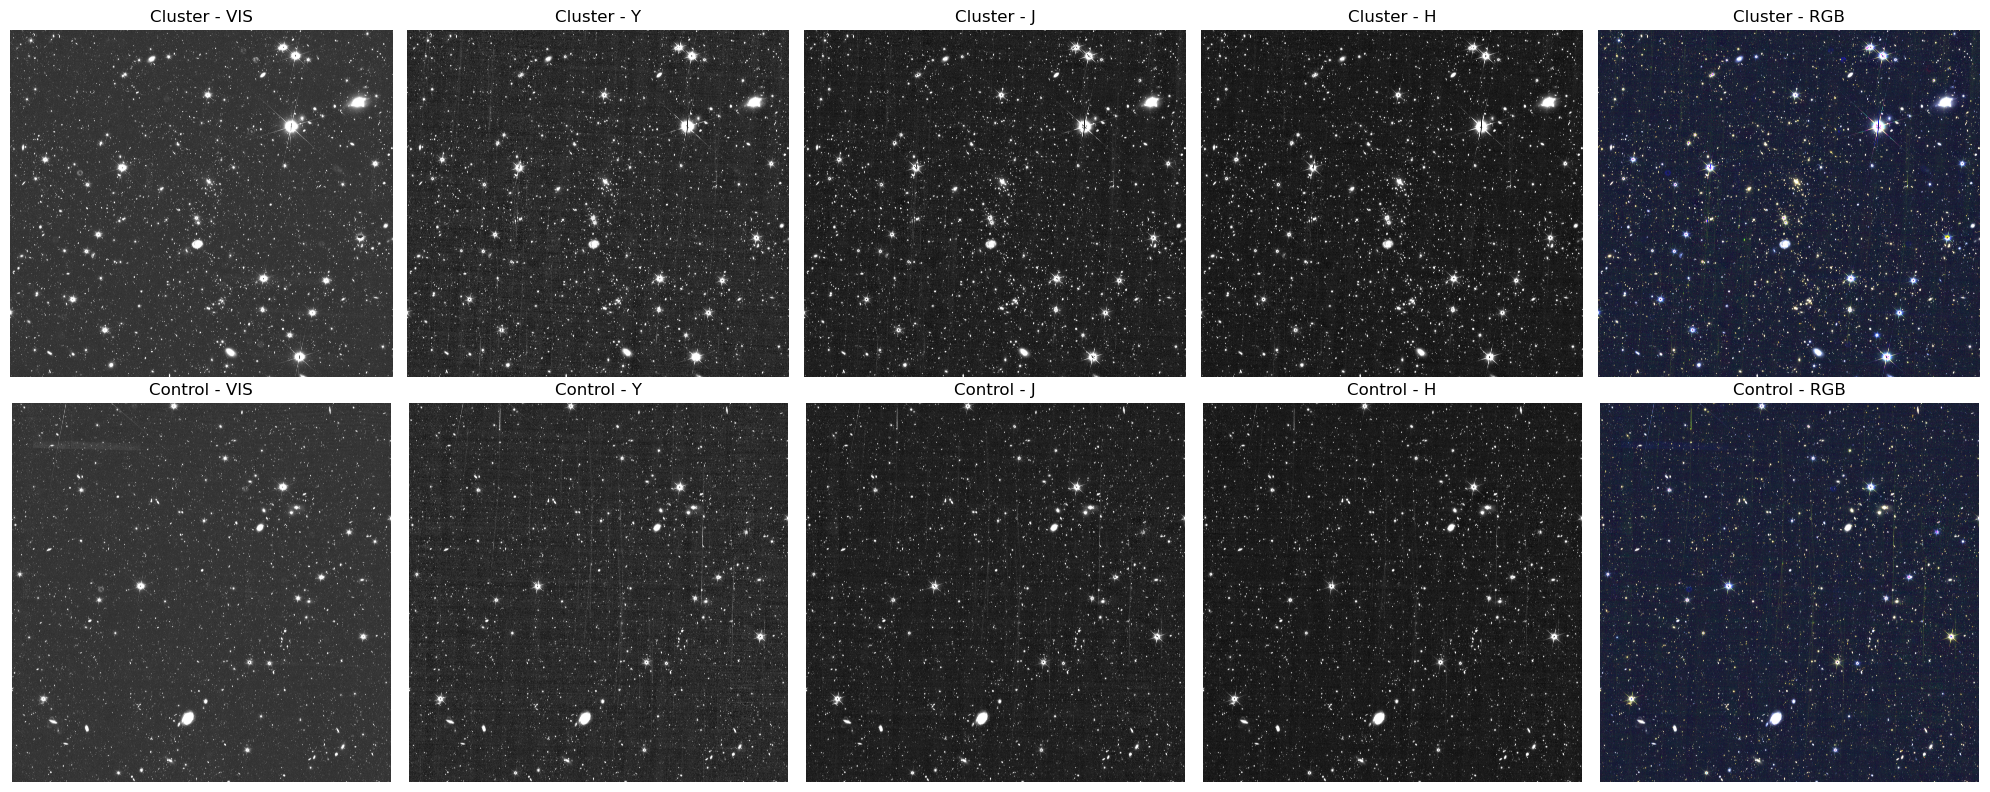

In [34]:
# Process both fields with consistent normalization
start_time = time.time()

print("Using consistent stretching between cluster and control fields...")
cluster_norm_cutouts, control_norm_cutouts, cluster_rgb, control_rgb = normalize_with_consistent_stretch(
    cluster_cutouts, control_cutouts, lower_percentile=1, upper_percentile=99
)

processing_time = time.time() - start_time
print(f"Processing complete! Time: {processing_time:.1f} seconds")

# Plot both fields side by side with consistent stretching
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
bands = ['VIS', 'Y', 'J', 'H']
titles = ['VIS', 'Y', 'J', 'H', 'RGB']

# Cluster field (top row)
for i, (band, title) in enumerate(zip(bands, titles)):
    axes[0, i].imshow(cluster_norm_cutouts[band], cmap='gray', origin='lower')
    axes[0, i].set_title(f'Cluster - {title}')
    axes[0, i].axis('off')

axes[0, 4].imshow(cluster_rgb, origin='lower')
axes[0, 4].set_title('Cluster - RGB')
axes[0, 4].axis('off')

# Control field (bottom row)
for i, (band, title) in enumerate(zip(bands, titles)):
    axes[1, i].imshow(control_norm_cutouts[band], cmap='gray', origin='lower')
    axes[1, i].set_title(f'Control - {title}')
    axes[1, i].axis('off')

axes[1, 4].imshow(control_rgb, origin='lower')
axes[1, 4].set_title('Control - RGB')
axes[1, 4].axis('off')

plt.tight_layout()
plt.show()


In [35]:
# Query galaxies in both fields with BOX search
table_mer = 'euclid_q1_mer_catalogue'
table_phz = 'euclid_q1_phz_photo_z'

# Convert cutout size to degrees
cutout_deg = im_cutout.to(u.deg).value

# Function to query galaxies for a field
def query_galaxies_for_field(ra, dec, field_name, redshift_center, redshift_width=0.1):
    """Query galaxies for a specific field with redshift slice"""
    print(f"\nQuerying galaxies for {field_name} field...")
    
    adql = (f"SELECT DISTINCT mer.object_id, mer.ra, mer.dec, "
            f"phz.flux_vis_unif, phz.flux_y_unif, phz.flux_j_unif, phz.flux_h_unif, "
            f"phz.phz_classification, phz.phz_median, phz.phz_90_int1, phz.phz_90_int2 "
            f"FROM {table_mer} AS mer "
            f"JOIN {table_phz} as phz "
            f"ON mer.object_id = phz.object_id "
            f"WHERE 1 = CONTAINS(POINT('ICRS', mer.ra, mer.dec), "
            f"BOX('ICRS', {ra}, {dec}, {cutout_deg/np.cos(np.radians(dec))}, {cutout_deg})) "
            f"AND phz.flux_vis_unif > 0 "
            f"AND phz.flux_y_unif > 0 "
            f"AND phz.flux_j_unif > 0 "
            f"AND phz.flux_h_unif > 0 "
            f"AND phz.phz_classification = 2 "
            f"AND ((phz.phz_90_int2 - phz.phz_90_int1) / (1 + phz.phz_median)) < 0.20 "
            f"AND phz.phz_median BETWEEN {redshift_center-redshift_width} AND {redshift_center+redshift_width}")
    
    result = Irsa.query_tap(adql).to_table()
    print(f"Found {len(result)} galaxies in {field_name} field (z = {redshift_center:.2f} ± {redshift_width:.2f})")
    
    return result

# Query galaxies for both fields in the cluster redshift slice
cluster_galaxies = query_galaxies_for_field(
    cluster['RAPZWav'], cluster['DecPZWav'], "cluster", 
    cluster['zPZWav'], redshift_width=0.12
)

control_galaxies = query_galaxies_for_field(
    control_ra, control_dec, "control", 
    cluster['zPZWav'], redshift_width=0.12
)

# Convert to pandas DataFrames for easier analysis
cluster_df_galaxies = cluster_galaxies.to_pandas()
control_df_galaxies = control_galaxies.to_pandas()

print(f"\nGalaxy counts summary:")
print(f"Cluster field: {len(cluster_galaxies)} galaxies")
print(f"Control field: {len(control_galaxies)} galaxies")
print(f"Ratio (cluster/control): {len(cluster_galaxies)/len(control_galaxies):.2f}")

cluster_df_galaxies.head()



Querying galaxies for cluster field...
Found 517 galaxies in cluster field (z = 0.55 ± 0.12)

Querying galaxies for control field...
Found 182 galaxies in control field (z = 0.55 ± 0.12)

Galaxy counts summary:
Cluster field: 517 galaxies
Control field: 182 galaxies
Ratio (cluster/control): 2.84


object_id         ra        dec  flux_vis_unif  flux_y_unif  \
0 -644253095477715114  64.425310 -47.771511       1.609485     2.669604   
1 -643507625477795504  64.350763 -47.779550       2.013760     5.094462   
2 -642962785477916703  64.296279 -47.791670       4.633417     5.555687   
3 -643069174478026251  64.306917 -47.802625      14.200328    45.893441   
4 -643027785477906423  64.302779 -47.790642       2.262524     2.899199   

   flux_j_unif  flux_h_unif  phz_classification  phz_median  phz_90_int1  \
0     2.620692     2.563696                   2        0.47         0.31   
1     6.801150     8.216345                   2        0.58         0.45   
2     6.882006     6.623519                   2        0.43         0.41   
3    68.414623    96.686749                   2        0.54         0.50   
4     3.082682     3.530153                   2        0.43         0.35   

   phz_90_int2  
0         0.60  
1         0.68  
2         0.49  
3         0.57  
4         0.55

## 5. Cluster Finding Algorithm

Apply DBSCAN clustering algorithm to identify clusters in both the cluster field and control field, a check both to confirm the cluster is there at that redshift and to identify some of the members ...

In [36]:
# Function to apply DBSCAN clustering with validity check (needed due to query/cutout mismatch)
def apply_dbscan_clustering(galaxy_df, wcs, rgb_image, field_name, eps=500, min_samples=18):
    """Apply DBSCAN clustering to galaxy coordinates from dataframe with validity check"""
    print(f"\nApplying DBSCAN clustering to {field_name} field...")
    
    # Convert galaxy coordinates to pixel coordinates
    galaxy_pixels = wcs.world_to_pixel_values(galaxy_df['ra'], galaxy_df['dec'])
    
    # Filter galaxies to only show those within the image bounds (needed due to query/cutout mismatch)
    image_height, image_width = rgb_image.shape[:2]
    valid_mask = ((galaxy_pixels[0] >= 0) & (galaxy_pixels[0] < image_width) & 
                  (galaxy_pixels[1] >= 0) & (galaxy_pixels[1] < image_height))
    
    valid_galaxy_coords = np.column_stack([galaxy_pixels[0][valid_mask], galaxy_pixels[1][valid_mask]])
    
    print(f"  Total galaxies: {len(galaxy_df)}")
    print(f"  Galaxies within image bounds: {valid_mask.sum()}")
    
    # Apply DBSCAN clustering only to valid galaxies
    clustering = DBSCAN(eps=eps, min_samples=min_samples).fit(valid_galaxy_coords)
    labels = clustering.labels_
    
    # Count clusters (excluding noise points labeled as -1)
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise = list(labels).count(-1)
    
    print(f"{field_name} field: {n_clusters} clusters, {n_noise} noise points")
    
    return labels, valid_galaxy_coords, n_clusters, n_noise

# Apply clustering to both fields (with validity check)
cluster_labels, cluster_galaxy_coords, cluster_n_clusters, cluster_n_noise = apply_dbscan_clustering(
    cluster_df_galaxies, cluster_cutout_wcs, cluster_rgb, "Cluster"
)

control_labels, control_galaxy_coords, control_n_clusters, control_n_noise = apply_dbscan_clustering(
    control_df_galaxies, control_cutout_wcs, control_rgb, "Control"
)

# Compare results
print(f"\nClustering Comparison:")
print(f"Cluster field: {cluster_n_clusters} clusters, {cluster_n_noise} noise points")
print(f"Control field: {control_n_clusters} clusters, {control_n_noise} noise points")
print(f"Cluster/Control ratio: {cluster_n_clusters/max(control_n_clusters, 1):.2f}")



Applying DBSCAN clustering to Cluster field...
  Total galaxies: 517
  Galaxies within image bounds: 499
Cluster field: 2 clusters, 268 noise points

Applying DBSCAN clustering to Control field...
  Total galaxies: 182
  Galaxies within image bounds: 182
Control field: 0 clusters, 182 noise points

Clustering Comparison:
Cluster field: 2 clusters, 268 noise points
Control field: 0 clusters, 182 noise points
Cluster/Control ratio: 2.00


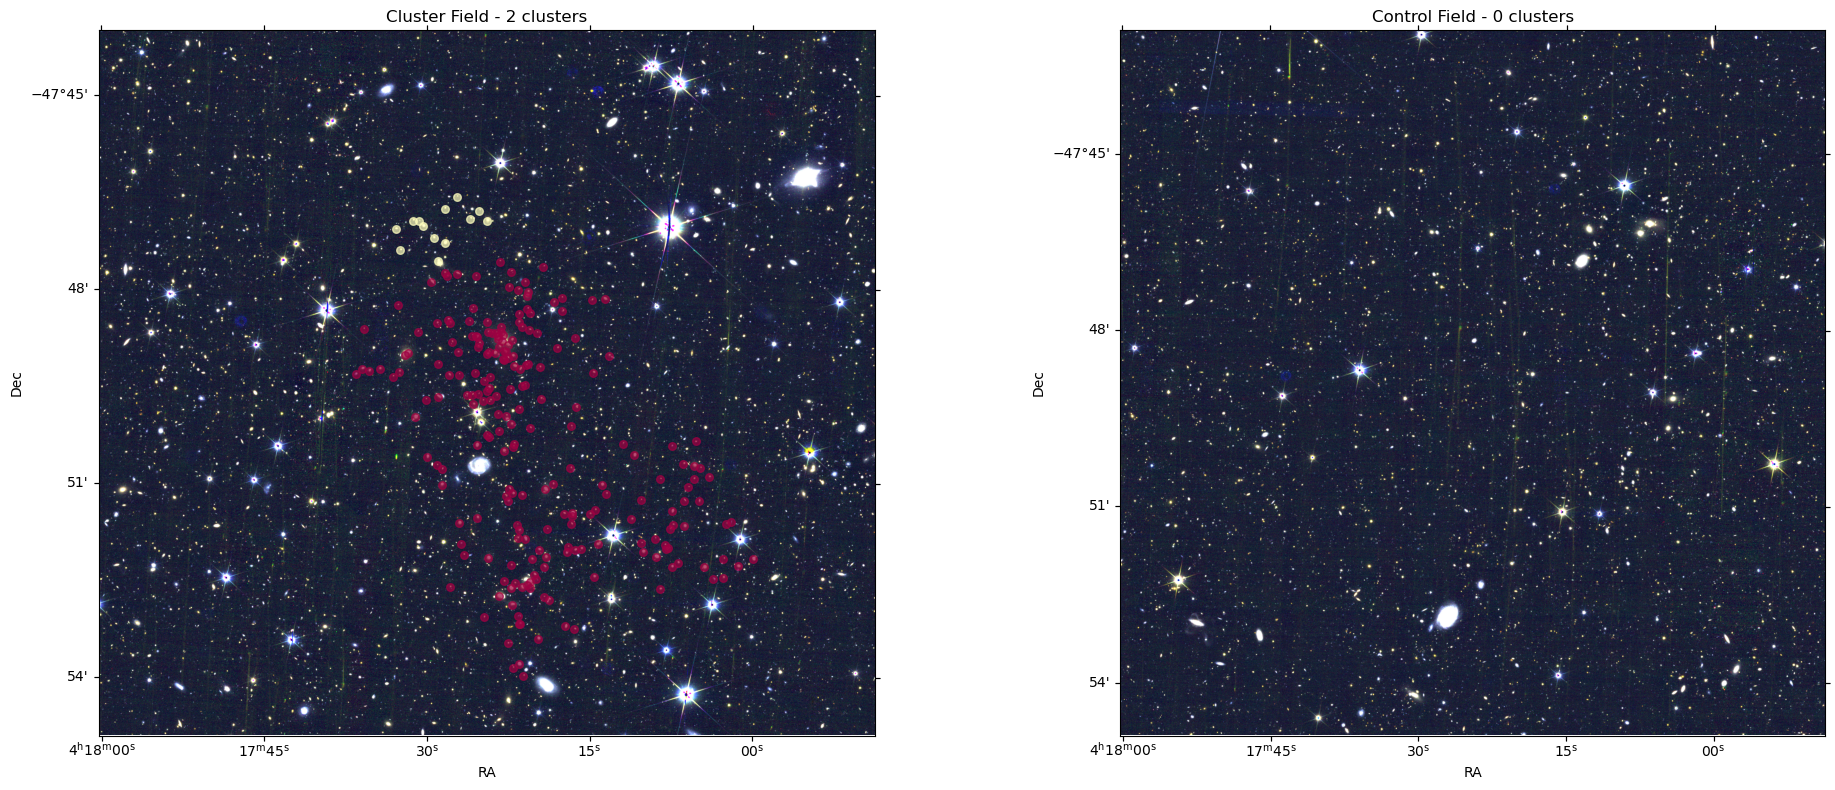

In [37]:
# Plot clustering results for both fields in one figure (1 row, 2 columns)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8), 
                               subplot_kw={'projection': cluster_cutout_wcs})

# Cluster field (left subplot)
ax1.imshow(cluster_rgb, origin='lower')
if len(cluster_labels) > 0:
    cluster_unique_labels = set(cluster_labels)
    cluster_colors = plt.cm.Spectral(np.linspace(0, 1, len(cluster_unique_labels)))

    for k, col in zip(cluster_unique_labels, cluster_colors):
        if k == -1:
            col = 'black'
            marker = ''
            size = 10
            alpha = 0.3
        else:
            marker = 'o'
            size = 30
            alpha = 0.7
        
        class_member_mask = (cluster_labels == k)
        xy = cluster_galaxy_coords[class_member_mask]
        if len(xy) > 0:  # Check if there are any points to plot
            ax1.scatter(xy[:, 0], xy[:, 1], c=[col], marker=marker, s=size, alpha=alpha)
else:
    print("No cluster data to plot")

ax1.set_xlabel('RA')
ax1.set_ylabel('Dec')
ax1.set_title(f'Cluster Field - {cluster_n_clusters} clusters')

# Control field (right subplot)
ax2.imshow(control_rgb, origin='lower')
if len(control_labels) > 0:
    control_unique_labels = set(control_labels)
    control_colors = plt.cm.Spectral(np.linspace(0, 1, len(control_unique_labels)))

    for k, col in zip(control_unique_labels, control_colors):
        if k == -1:
            col = 'black'
            marker = ''
            size = 10
            alpha = 0.3
        else:
            marker = 'o'
            size = 30
            alpha = 0.7
        
        class_member_mask = (control_labels == k)
        xy = control_galaxy_coords[class_member_mask]
        if len(xy) > 0:  # Check if there are any points to plot
            ax2.scatter(xy[:, 0], xy[:, 1], c=[col], marker=marker, s=size, alpha=alpha)
else:
    print("No control field data to plot")

ax2.set_xlabel('RA')
ax2.set_ylabel('Dec')
ax2.set_title(f'Control Field - {control_n_clusters} clusters')

plt.tight_layout()
plt.show()


## 6. Color-Magnitude Diagram Analysis

We analyze the color-magnitude properties of cluster and field galaxies to understand their stellar populations and star formation histories. The Y-H color vs H magnitude diagram reveals differences in galaxy properties between cluster and field environments.


In [38]:
# Function to identify cluster members and field galaxies
def identify_cluster_members(galaxy_df, labels, galaxy_coords, field_name):
    """
    Identify which galaxies belong to clusters vs field galaxies.
    Returns cluster members and field galaxies separately.
    """
    print(f"\nAnalyzing {field_name} field galaxy populations...")
    
    # The labels array corresponds to the galaxies that were actually used in clustering
    # (those within image bounds). We need to create a mapping.
    
    # Get the WCS for coordinate conversion
    if field_name == "Cluster":
        wcs = cluster_cutout_wcs
        rgb_image = cluster_rgb
    else:
        wcs = control_cutout_wcs
        rgb_image = control_rgb
    
    # Convert galaxy coordinates to pixel coordinates
    galaxy_pixels = wcs.world_to_pixel_values(galaxy_df['ra'], galaxy_df['dec'])
    
    # Filter galaxies to only show those within the image bounds (same as in clustering)
    image_height, image_width = rgb_image.shape[:2]
    valid_mask = ((galaxy_pixels[0] >= 0) & (galaxy_pixels[0] < image_width) & 
                  (galaxy_pixels[1] >= 0) & (galaxy_pixels[1] < image_height))
    
    # Get only the valid galaxies (those used in clustering)
    valid_galaxies = galaxy_df[valid_mask].copy()
    
    print(f"  Total galaxies in catalog: {len(galaxy_df)}")
    print(f"  Galaxies within image bounds: {len(valid_galaxies)}")
    print(f"  Labels array length: {len(labels)}")
    
    # Now the labels array should match the valid_galaxies DataFrame
    if len(valid_galaxies) != len(labels):
        print(f"  WARNING: Mismatch between valid galaxies ({len(valid_galaxies)}) and labels ({len(labels)})")
        # Use the minimum length to avoid errors
        min_len = min(len(valid_galaxies), len(labels))
        valid_galaxies = valid_galaxies.iloc[:min_len]
        labels = labels[:min_len]
    
    # Create a mask for cluster members (labels != -1)
    cluster_member_mask = labels != -1
    field_galaxy_mask = labels == -1
    
    # Get cluster members and field galaxies
    cluster_members = valid_galaxies[cluster_member_mask].copy()
    field_galaxies = valid_galaxies[field_galaxy_mask].copy()
    
    # Add cluster assignment information
    cluster_members['cluster_id'] = labels[cluster_member_mask]
    field_galaxies['cluster_id'] = -1  # Field galaxies
    
    print(f"  Cluster members: {len(cluster_members)} galaxies")
    print(f"  Field galaxies: {len(field_galaxies)} galaxies")
    
    # Count galaxies per cluster
    if len(cluster_members) > 0:
        cluster_counts = cluster_members['cluster_id'].value_counts().sort_index()
    
    return cluster_members, field_galaxies

# Analyze both fields
cluster_members_cluster_field, field_galaxies_cluster_field = identify_cluster_members(
    cluster_df_galaxies, cluster_labels, cluster_galaxy_coords, "Cluster"
)

cluster_members_control_field, field_galaxies_control_field = identify_cluster_members(
    control_df_galaxies, control_labels, control_galaxy_coords, "Control"
)

# Combine all field galaxies (from both cluster and control fields)
all_field_galaxies = pd.concat([field_galaxies_cluster_field, field_galaxies_control_field], ignore_index=True)

# Combine all cluster members
all_cluster_members = pd.concat([cluster_members_cluster_field], ignore_index=True)

print(f"\nOverall Summary:")
print(f"Total cluster members: {len(all_cluster_members)}")
print(f"Total field galaxies: {len(all_field_galaxies)}")


Analyzing Cluster field galaxy populations...
  Total galaxies in catalog: 517
  Galaxies within image bounds: 499
  Labels array length: 499
  Cluster members: 231 galaxies
  Field galaxies: 268 galaxies

Analyzing Control field galaxy populations...
  Total galaxies in catalog: 182
  Galaxies within image bounds: 182
  Labels array length: 182
  Cluster members: 0 galaxies
  Field galaxies: 182 galaxies

Overall Summary:
Total cluster members: 231
Total field galaxies: 450


Removing outliers outside plot boundaries...
Cluster galaxies: 231 -> 229 (removed 2)
Field galaxies: 450 -> 435 (removed 15)


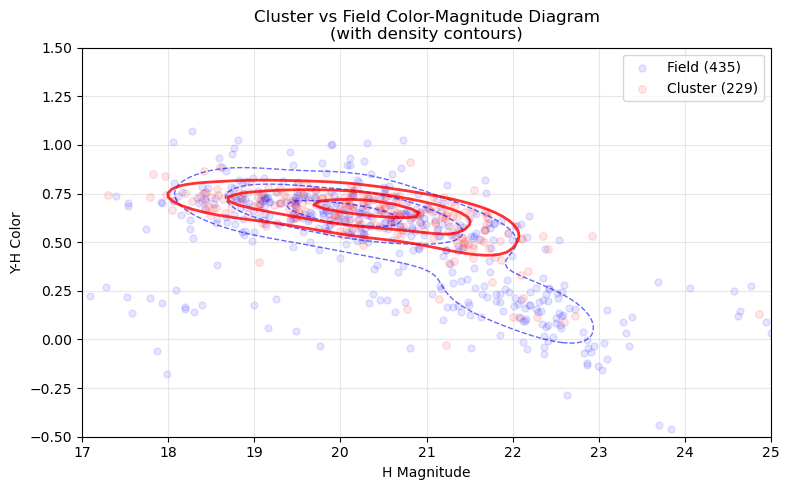

In [39]:
# Create simplified Y-H vs H color-magnitude diagram with density contours
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

# Calculate Y-H color and H magnitude
def calculate_color_magnitude(df):
    """Calculate Y-H color and H magnitude from flux data"""
    df = df.copy()
    
    # Convert fluxes to magnitudes (using -2.5 * log10(flux))
    # Note: These are instrumental magnitudes, not absolute magnitudes
    df['H_mag'] = -2.5 * np.log10(df['flux_h_unif'])+23.9
    df['Y_mag'] = -2.5 * np.log10(df['flux_y_unif'])+23.9
    
    # Calculate Y-H color
    df['Y_H_color'] = df['Y_mag'] - df['H_mag']
    
    return df

# Calculate color-magnitude properties using only the needed fluxes
cluster_cmd = calculate_color_magnitude(all_cluster_members[['flux_y_unif', 'flux_h_unif']])
field_cmd = calculate_color_magnitude(all_field_galaxies[['flux_y_unif', 'flux_h_unif']])

# Remove outliers using plot boundaries (much simpler and more intuitive)
def remove_outliers_bounds(df, h_min=17, h_max=25, yh_min=-0.5, yh_max=1.5):
    """Remove outliers outside the plot boundaries"""
    df_clean = df.copy()
    df_clean = df_clean[
        (df_clean['H_mag'] >= h_min) & (df_clean['H_mag'] <= h_max) &
        (df_clean['Y_H_color'] >= yh_min) & (df_clean['Y_H_color'] <= yh_max)
    ]
    return df_clean

# Remove outliers from both populations (using plot boundaries)
print("Removing outliers outside plot boundaries...")
cluster_cmd_clean = remove_outliers_bounds(cluster_cmd)
field_cmd_clean = remove_outliers_bounds(field_cmd)

print(f"Cluster galaxies: {len(cluster_cmd)} -> {len(cluster_cmd_clean)} (removed {len(cluster_cmd) - len(cluster_cmd_clean)})")
print(f"Field galaxies: {len(field_cmd)} -> {len(field_cmd_clean)} (removed {len(field_cmd) - len(field_cmd_clean)})")

# Plot comparison with lower alpha for better visibility
ax.scatter(field_cmd_clean['H_mag'], field_cmd_clean['Y_H_color'], 
          c='blue', alpha=0.1, s=25, label=f'Field ({len(field_cmd_clean)})')
ax.scatter(cluster_cmd_clean['H_mag'], cluster_cmd_clean['Y_H_color'], 
          c='red', alpha=0.1, s=30, label=f'Cluster ({len(cluster_cmd_clean)})')

# Add density contours to show the tightness of each population

# Create density contours for field galaxies (using cleaned data)
if len(field_cmd_clean) > 10:  # Need enough points for meaningful contours
    field_h = field_cmd_clean['H_mag'].values
    field_yh = field_cmd_clean['Y_H_color'].values
    field_xy = np.vstack([field_h, field_yh])
    field_density = gaussian_kde(field_xy)
    
    # Create grid for contour plot
    h_grid = np.linspace(17, 25, 100)
    yh_grid = np.linspace(-0.5, 1.5, 100)
    H_grid, YH_grid = np.meshgrid(h_grid, yh_grid)
    positions = np.vstack([H_grid.ravel(), YH_grid.ravel()])
    field_z = np.reshape(field_density(positions).T, H_grid.shape)
    
    # Plot field contours
    ax.contour(H_grid, YH_grid, field_z, levels=3, colors='blue', alpha=0.6, linestyles='--', linewidths=1)

# Create density contours for cluster galaxies (using cleaned data)
if len(cluster_cmd_clean) > 10:  # Need enough points for meaningful contours
    cluster_h = cluster_cmd_clean['H_mag'].values
    cluster_yh = cluster_cmd_clean['Y_H_color'].values
    cluster_xy = np.vstack([cluster_h, cluster_yh])
    cluster_density = gaussian_kde(cluster_xy)
    
    # Use same grid
    cluster_z = np.reshape(cluster_density(positions).T, H_grid.shape)
    
    # Plot cluster contours
    ax.contour(H_grid, YH_grid, cluster_z, levels=3, colors='red', alpha=0.8, linestyles='-', linewidths=2)

ax.set_xlabel('H Magnitude')
ax.set_ylabel('Y-H Color')
ax.set_title('Cluster vs Field Color-Magnitude Diagram\n(with density contours)')
ax.grid(True, alpha=0.3)
ax.legend()

# Set axis limits as requested
ax.set_xlim(17, 25)  # H magnitude range
ax.set_ylim(-0.5, 1.5)  # Y-H color range

plt.tight_layout()
plt.show()

## About this Notebook

**Author(s)**: Shoubaneh Hemmati <br>
**Keyword(s)**: Euclid, Q1, AAS 247 Workshop <br>
**First published**: Dec 17, 2025 <br>
**Last updated**: Dec 17, 2025